In [1]:
%pip install -U "jax[cuda]"

In [2]:
%pip install -U "git+https://github.com/briancf1/QDax.git#egg=qdax[examples]"

DEPRECATION: git+https://github.com/briancf1/QDax.git#egg=qdax[examples] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/briancf1/QDax.git to /tmp/pip-install-trr7kdp5/qdax_1708264f90d74d3cb06fab48dade750c
  Running command git clone --filter=blob:none --quiet https://github.com/briancf1/QDax.git /tmp/pip-install-trr7kdp5/qdax_1708264f90d74d3cb06fab48dade750c
  Resolved https://github.com/briancf1/QDax.git to commit 996be54157bee33762efb26f1649688d3ff84f81
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
# Clone the repository to get experiment scripts
!git clone https://github.com/briancf1/QDax.git
%cd QDax/examples

fatal: destination path 'QDax' already exists and is not an empty directory.
/content/QDax/examples


## Setup and Imports

In [4]:
import os
import subprocess
import json
import time
from datetime import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create experiment logs directory
os.makedirs("experiment_logs", exist_ok=True)

print("Setup complete!")
print(f"Current directory: {os.getcwd()}")

Setup complete!
Current directory: /content/QDax/examples


## Helper Functions

In [5]:
def run_script(script_name, log_suffix):
    """
    Run a Python script and capture output to log file.

    Args:
        script_name: Name of the Python script to run
        log_suffix: Suffix for the log file

    Returns:
        Tuple of (success, runtime_seconds, log_file)
    """
    log_file = f"experiment_logs/{log_suffix}.log"
    print(f"\n{'='*80}")
    print(f"Running: {script_name}")
    print(f"Log file: {log_file}")
    print(f"{'='*80}")

    start_time = time.time()

    try:
        with open(log_file, 'w') as f:
            process = subprocess.Popen(
                ['python', '-u', script_name],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                text=True,
                bufsize=1
            )

            # Stream output to both log file and notebook
            for line in process.stdout:
                print(line, end='')
                f.write(line)

            process.wait()
            runtime = time.time() - start_time

            if process.returncode == 0:
                print(f"\n✓ SUCCESS - Runtime: {runtime:.1f}s")
                return True, runtime, log_file
            else:
                print(f"\n✗ FAILED - Exit code: {process.returncode}")
                return False, runtime, log_file

    except Exception as e:
        runtime = time.time() - start_time
        print(f"\n✗ ERROR: {e}")
        return False, runtime, log_file


def summarize_results(results_json_path):
    """
    Load and display summary from results JSON.

    Args:
        results_json_path: Path to the results JSON file

    Returns:
        DataFrame with results
    """
    try:
        with open(results_json_path, 'r') as f:
            data = json.load(f)

        results = data.get('results', [])
        if not results:
            print(f"No results found in {results_json_path}")
            return None

        df = pd.DataFrame(results)
        return df

    except FileNotFoundError:
        print(f"Results file not found: {results_json_path}")
        return None
    except Exception as e:
        print(f"Error loading results: {e}")
        return None

print("Helper functions loaded!")

Helper functions loaded!


## 1. Run Baseline DNS Experiments

Tests different mutation strengths (iso_sigma) to determine if mutation tuning alone improves DNS performance.

In [6]:
baseline_success, baseline_time, baseline_log = run_script(
    'run_baselines.py',
    'baselines'
)

print(f"\nBaseline experiments {'completed' if baseline_success else 'failed'}")
print(f"Total runtime: {baseline_time:.1f}s ({baseline_time/60:.1f} minutes)")


Running: run_baselines.py
Log file: experiment_logs/baselines.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
reached

DNS Baseline Experiments - 20251115_180344
Output directory: dns_baselines_20251115_180344
Total experiments: 3
Purpose: Test if iso_sigma affects DNS performance


################################################################################
# Experiment 1/3
################################################################################

Running: DNS_baseline_iso0.005
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
Config: Standard DNS, iso_sigma=0.005
Initial - QD: 22903.06, Ma

### Baseline Results Summary

In [7]:
# Find the most recent baseline results directory
baseline_dirs = sorted([d for d in os.listdir('.') if d.startswith('dns_baselines_')])
if baseline_dirs:
    latest_baseline = baseline_dirs[-1]
    baseline_results_path = os.path.join(latest_baseline, 'baseline_results.json')

    baseline_df = summarize_results(baseline_results_path)
    if baseline_df is not None:
        print("\nBaseline DNS Results:")
        print(baseline_df[['name', 'final_qd_score', 'final_max_fitness', 'final_coverage', 'total_time']].to_string(index=False))
else:
    print("No baseline results found yet")


Baseline DNS Results:
                 name  final_qd_score  final_max_fitness  final_coverage  total_time
DNS_baseline_iso0.005     378104.0625         275.469696           100.0  247.911158
 DNS_baseline_iso0.01     413590.4375         320.468384           100.0  246.595540
DNS_baseline_iso0.003     385377.7500         285.126007           100.0  247.268426


## 2. Run Tier 1: Proven Winners

Top 3 configurations from initial results (g300_gen2, g614_gen2, g250_gen1).

In [8]:
tier1_success, tier1_time, tier1_log = run_script(
    'run_tier1_proven_winners.py',
    'tier1_proven_winners'
)

print(f"\nTier 1 experiments {'completed' if tier1_success else 'failed'}")
print(f"Total runtime: {tier1_time:.1f}s ({tier1_time/60:.1f} minutes)")


Running: run_tier1_proven_winners.py
Log file: experiment_logs/tier1_proven_winners.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Loaded baseline target from dns_baselines_20251115_180344/baseline_results.json: 378104.06
reached

DNS-GA Tier 1: Proven Winners - 20251115_181728
Output directory: dns_ga_tier1_20251115_181728
Total experiments: 3


################################################################################
# Experiment 1/3
################################################################################

Running: DNS-GA_g300_gen2_iso0.005
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.

### Tier 1 Results Summary

In [9]:
tier1_dirs = sorted([d for d in os.listdir('.') if d.startswith('dns_ga_tier1_')])
if tier1_dirs:
    latest_tier1 = tier1_dirs[-1]
    tier1_results_path = os.path.join(latest_tier1, 'tier1_results.json')

    tier1_df = summarize_results(tier1_results_path)
    if tier1_df is not None:
        print("\nTier 1 Results:")
        display_cols = ['name', 'final_qd_score', 'convergence_iter']
        if 'net_eval_savings_pct' in tier1_df.columns:
            display_cols.extend(['eval_savings_pct', 'net_eval_savings_pct'])
        else:
            display_cols.extend(['eval_savings_pct'])
        print(tier1_df[display_cols].to_string(index=False))
else:
    print("No tier 1 results found yet")


Tier 1 Results:
                     name  final_qd_score  convergence_iter  eval_savings_pct  net_eval_savings_pct
DNS-GA_g300_gen2_iso0.005    375517.46875               NaN               NaN                   NaN
DNS-GA_g614_gen2_iso0.005    384508.62500            2100.0         30.000000             23.856000
DNS-GA_g250_gen1_iso0.005    379744.81250            2600.0         13.333333              6.506667


## 3. Run Tier 2: Promising Configurations

Low-overhead configurations (g500_gen1, g400_gen2).

In [10]:
tier2_success, tier2_time, tier2_log = run_script(
    'run_tier2_promising.py',
    'tier2_promising'
)

print(f"\nTier 2 experiments {'completed' if tier2_success else 'failed'}")
print(f"Total runtime: {tier2_time:.1f}s ({tier2_time/60:.1f} minutes)")


Running: run_tier2_promising.py
Log file: experiment_logs/tier2_promising.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Loaded baseline target from dns_baselines_20251115_180344/baseline_results.json: 378104.06
reached

DNS-GA Tier 2: Promising Variants - 20251115_183320
Output directory: dns_ga_tier2_20251115_183320
Total experiments: 2


################################################################################
# Experiment 1/2
################################################################################

Running: DNS-GA_g500_gen1_iso0.005
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


## 4. Run Tier 3: Deep Foresight

Deeper forecasting with 3-4 generations (g500_gen3, g700_gen3, g1000_gen4).

In [5]:
tier3_success, tier3_time, tier3_log = run_script(
    'run_tier3_deep_foresight.py',
    'tier3_deep_foresight'
)

print(f"\nTier 3 experiments {'completed' if tier3_success else 'failed'}")
print(f"Total runtime: {tier3_time:.1f}s ({tier3_time/60:.1f} minutes)")


Running: run_tier3_deep_foresight.py
Log file: experiment_logs/tier3_deep_foresight.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Loaded baseline target from dns_baselines_20251115_121039/baseline_results.json: 375886.50
reached

DNS-GA Tier 3: Deeper Foresight - 20251115_171829
Output directory: dns_ga_tier3_20251115_171829
Total experiments: 3


################################################################################
# Experiment 1/3
################################################################################

Running: DNS-GA_g500_gen3_iso0.01
/Users/briancf/Desktop/source/EvoAlgsAndSwarm/lib-qdax/QDax/.venv/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://githu

KeyboardInterrupt: 

## 5. Run Tier 4: Aggressive Frequency

Very frequent GA calls (g150_gen1, g200_gen2) to test overhead limits.

In [12]:
tier4_success, tier4_time, tier4_log = run_script(
    'run_tier4_aggressive.py',
    'tier4_aggressive'
)

print(f"\nTier 4 experiments {'completed' if tier4_success else 'failed'}")
print(f"Total runtime: {tier4_time:.1f}s ({tier4_time/60:.1f} minutes)")


Running: run_tier4_aggressive.py
Log file: experiment_logs/tier4_aggressive.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Loaded baseline target from dns_baselines_20251115_180344/baseline_results.json: 378104.06
reached

DNS-GA Tier 4: Aggressive Frequency - 20251115_190039
Output directory: dns_ga_tier4_20251115_190039
Total experiments: 2


################################################################################
# Experiment 1/2
################################################################################

Running: DNS-GA_g150_gen1_iso0.005
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.wa

## 6. Run Tier 5: Rare Deep Forecasting

Rare but very deep forecasting (g1000_gen5, g1500_gen5) with 5 generations.

In [13]:
tier5_success, tier5_time, tier5_log = run_script(
    'run_tier5_rare_deep.py',
    'tier5_rare_deep'
)

print(f"\nTier 5 experiments {'completed' if tier5_success else 'failed'}")
print(f"Total runtime: {tier5_time:.1f}s ({tier5_time/60:.1f} minutes)")


Running: run_tier5_rare_deep.py
Log file: experiment_logs/tier5_rare_deep.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'
Loaded baseline target from dns_baselines_20251115_180344/baseline_results.json: 378104.06
reached

DNS-GA Tier 5: Rare But Deep - 20251115_191123
Output directory: dns_ga_tier5_20251115_191123
Total experiments: 2


################################################################################
# Experiment 1/2
################################################################################

Running: DNS-GA_g1000_gen5_iso0.005
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
Conf

## 7. Run Adaptive Experiments

Tests dynamic g_n scheduling strategies where Competition-GA frequency changes during evolution.

In [14]:
adaptive_success, adaptive_time, adaptive_log = run_script(
    'run_adaptive_experiments.py',
    'adaptive_experiments'
)

print(f"\nAdaptive experiments {'completed' if adaptive_success else 'failed'}")
print(f"Total runtime: {adaptive_time:.1f}s ({adaptive_time/60:.1f} minutes)")


Running: run_adaptive_experiments.py
Log file: experiment_logs/adaptive_experiments.log
Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'

DNS-GA Adaptive Frequency Experiments - 20251115_192303
Output directory: dns_ga_adaptive_20251115_192303

Experiment: adaptive_early_frequent_g100to500
Description: Frequent GA early for exploration, rare GA late for stability

Running: adaptive_early_frequent_g100to500
/usr/local/lib/python3.12/dist-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
Starting with g_n=100
Initial - QD: 22903.06, MaxFit: 179.28, Coverage: 9.77
Iter 101/3000 (g_n=100) - QD: 317314.56, MaxFit: 218.37, Cov: 100.00%
Iter 20

### Adaptive Results Summary

In [15]:
adaptive_dirs = sorted([d for d in os.listdir('.') if d.startswith('dns_ga_adaptive_')])
if adaptive_dirs:
    latest_adaptive = adaptive_dirs[-1]
    adaptive_results_path = os.path.join(latest_adaptive, 'adaptive_results.json')

    adaptive_df = summarize_results(adaptive_results_path)
    if adaptive_df is not None:
        print("\nAdaptive Experiment Results:")
        print(adaptive_df[['name', 'final_qd_score', 'final_max_fitness', 'final_coverage']].to_string(index=False))
else:
    print("No adaptive results found yet")


Adaptive Experiment Results:
                             name  final_qd_score  final_max_fitness  final_coverage
adaptive_early_frequent_g100to500     374714.3125         267.874054           100.0
 adaptive_late_frequent_g500to100     378508.5000         280.585358           100.0
             adaptive_three_phase     374714.3125         267.874054           100.0


## 8. Comprehensive Analysis

Now let's analyze and visualize all results together.

In [16]:
# Collect all results
all_results = []

# Baseline results
if baseline_dirs:
    baseline_df = summarize_results(os.path.join(baseline_dirs[-1], 'baseline_results.json'))
    if baseline_df is not None:
        baseline_df['category'] = 'Baseline'
        all_results.append(baseline_df)

# Tier results
for tier_num in range(1, 6):
    tier_dirs = sorted([d for d in os.listdir('.') if d.startswith(f'dns_ga_tier{tier_num}_')])
    if tier_dirs:
        tier_df = summarize_results(os.path.join(tier_dirs[-1], f'tier{tier_num}_results.json'))
        if tier_df is not None:
            tier_df['category'] = f'Tier {tier_num}'
            all_results.append(tier_df)

# Adaptive results
if adaptive_dirs:
    adaptive_df = summarize_results(os.path.join(adaptive_dirs[-1], 'adaptive_results.json'))
    if adaptive_df is not None:
        adaptive_df['category'] = 'Adaptive'
        all_results.append(adaptive_df)

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal experiments analyzed: {len(combined_df)}")
    print("\nCategories:")
    print(combined_df['category'].value_counts())
else:
    print("No results to analyze yet")
    combined_df = None


Total experiments analyzed: 18

Categories:
category
Baseline    3
Tier 1      3
Tier 3      3
Adaptive    3
Tier 2      2
Tier 4      2
Tier 5      2
Name: count, dtype: int64


/tmp/ipython-input-1630021841.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(all_results, ignore_index=True)


### Visualization: Final QD Scores

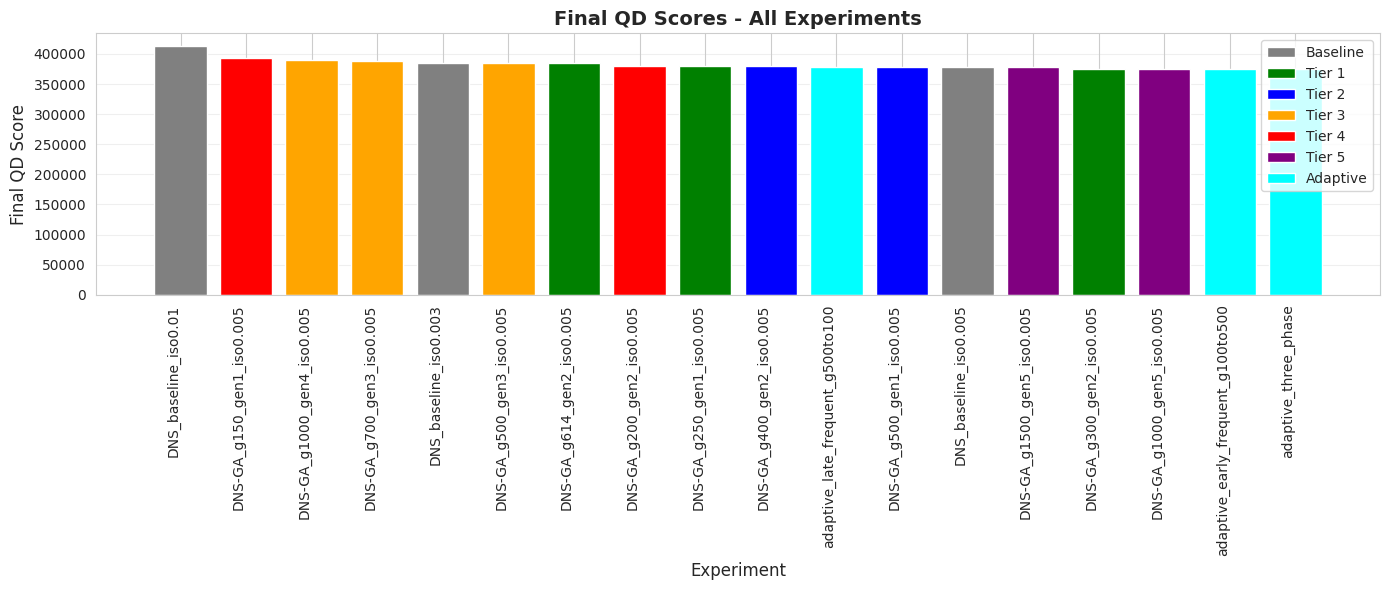


Top 5 Experiments by QD Score:
                      name category  final_qd_score
      DNS_baseline_iso0.01 Baseline     413590.4375
 DNS-GA_g150_gen1_iso0.005   Tier 4     393937.1250
DNS-GA_g1000_gen4_iso0.005   Tier 3     390150.0625
 DNS-GA_g700_gen3_iso0.005   Tier 3     388602.9375
     DNS_baseline_iso0.003 Baseline     385377.7500


In [17]:
if combined_df is not None:
    plt.figure(figsize=(14, 6))

    # Sort by QD score
    plot_df = combined_df.sort_values('final_qd_score', ascending=False)

    # Create bar plot
    colors = {'Baseline': 'gray', 'Tier 1': 'green', 'Tier 2': 'blue',
              'Tier 3': 'orange', 'Tier 4': 'red', 'Tier 5': 'purple', 'Adaptive': 'cyan'}

    bars = plt.bar(range(len(plot_df)), plot_df['final_qd_score'],
                   color=[colors.get(cat, 'lightgray') for cat in plot_df['category']])

    plt.xlabel('Experiment', fontsize=12)
    plt.ylabel('Final QD Score', fontsize=12)
    plt.title('Final QD Scores - All Experiments', fontsize=14, fontweight='bold')
    plt.xticks(range(len(plot_df)), plot_df['name'], rotation=90, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', alpha=0.3)

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in colors.keys() if cat in plot_df['category'].values]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.show()

    # Print top 5
    print("\nTop 5 Experiments by QD Score:")
    print(plot_df[['name', 'category', 'final_qd_score']].head().to_string(index=False))

### Visualization: Evaluation Savings (DNS-GA only)

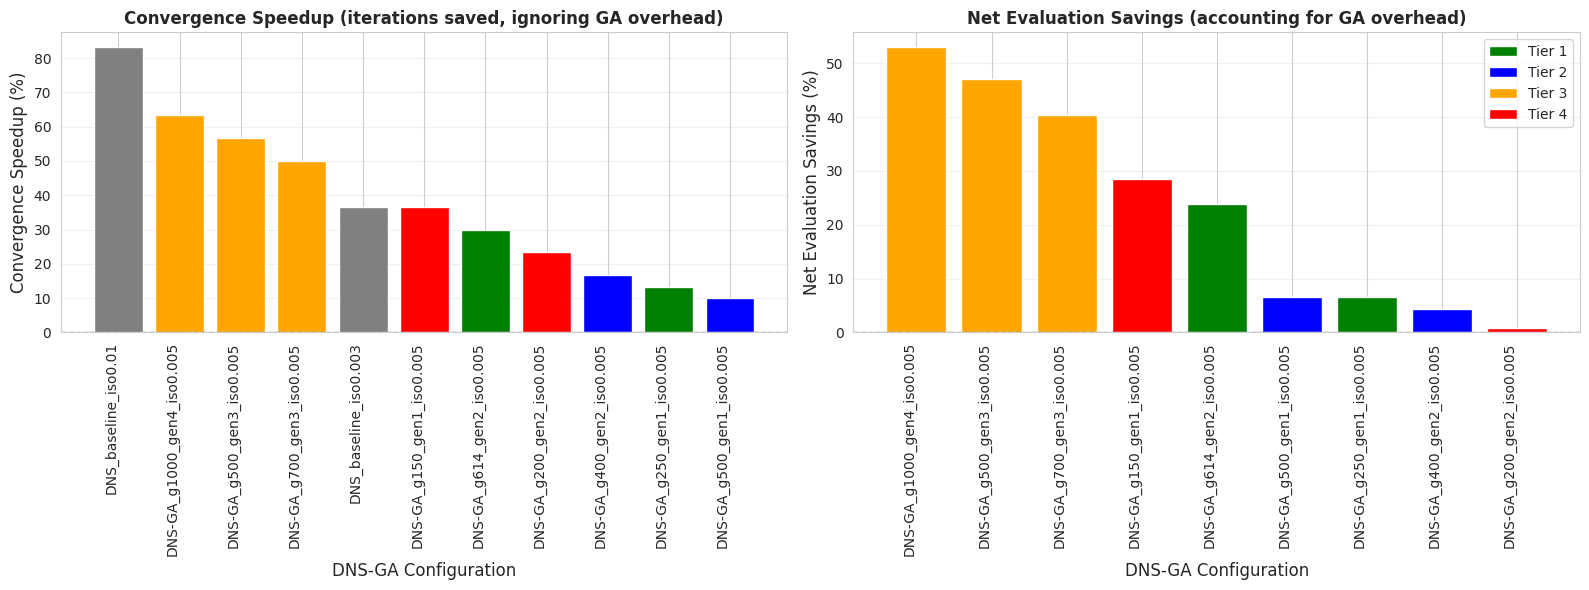


Top 5 by Convergence Speedup:
                      name  eval_savings_pct  convergence_iter
      DNS_baseline_iso0.01         83.333333             500.0
DNS-GA_g1000_gen4_iso0.005         63.333333            1100.0
 DNS-GA_g500_gen3_iso0.005         56.666667            1300.0
 DNS-GA_g700_gen3_iso0.005         50.000000            1500.0
     DNS_baseline_iso0.003         36.666667            1900.0

Top 5 by Net Evaluation Savings (accounting for GA overhead):
                      name  net_eval_savings_pct  convergence_iter  dns_ga_total_evals
DNS-GA_g1000_gen4_iso0.005             53.093333            1100.0            140720.0
 DNS-GA_g500_gen3_iso0.005             47.109333            1300.0            158672.0
 DNS-GA_g700_gen3_iso0.005             40.442667            1500.0            178672.0
 DNS-GA_g150_gen1_iso0.005             28.474667            1900.0            214576.0
 DNS-GA_g614_gen2_iso0.005             23.856000            2100.0            228432.0


In [18]:
if combined_df is not None and 'eval_savings_pct' in combined_df.columns:
    ga_df = combined_df[combined_df['eval_savings_pct'].notna()].copy()

    if len(ga_df) > 0:
        # Create two subplots: convergence speedup vs net savings
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Plot 1: Convergence speedup (ignoring overhead)
        ga_df_sorted = ga_df.sort_values('eval_savings_pct', ascending=False)
        bars1 = ax1.bar(range(len(ga_df_sorted)), ga_df_sorted['eval_savings_pct'],
                       color=[colors.get(cat, 'lightgray') for cat in ga_df_sorted['category']])
        ax1.set_xlabel('DNS-GA Configuration', fontsize=12)
        ax1.set_ylabel('Convergence Speedup (%)', fontsize=12)
        ax1.set_title('Convergence Speedup (iterations saved, ignoring GA overhead)', fontsize=12, fontweight='bold')
        ax1.set_xticks(range(len(ga_df_sorted)))
        ax1.set_xticklabels(ga_df_sorted['name'], rotation=90, ha='right')
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax1.grid(axis='y', alpha=0.3)

        # Plot 2: Net evaluation savings (accounting for overhead)
        if 'net_eval_savings_pct' in ga_df.columns:
            ga_df_net = ga_df[ga_df['net_eval_savings_pct'].notna()].sort_values('net_eval_savings_pct', ascending=False)
            bars2 = ax2.bar(range(len(ga_df_net)), ga_df_net['net_eval_savings_pct'],
                           color=[colors.get(cat, 'lightgray') for cat in ga_df_net['category']])
            ax2.set_xlabel('DNS-GA Configuration', fontsize=12)
            ax2.set_ylabel('Net Evaluation Savings (%)', fontsize=12)
            ax2.set_title('Net Evaluation Savings (accounting for GA overhead)', fontsize=12, fontweight='bold')
            ax2.set_xticks(range(len(ga_df_net)))
            ax2.set_xticklabels(ga_df_net['name'], rotation=90, ha='right')
            ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
            ax2.grid(axis='y', alpha=0.3)

            # Add legend to second plot
            legend_elements = [Patch(facecolor=colors[cat], label=cat) for cat in colors.keys() if cat in ga_df_net['category'].values]
            ax2.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()
        plt.show()

        print("\nTop 5 by Convergence Speedup:")
        print(ga_df_sorted[['name', 'eval_savings_pct', 'convergence_iter']].head().to_string(index=False))

        if 'net_eval_savings_pct' in ga_df.columns:
            print("\nTop 5 by Net Evaluation Savings (accounting for GA overhead):")
            display_cols = ['name', 'net_eval_savings_pct', 'convergence_iter', 'dns_ga_total_evals']
            available_cols = [col for col in display_cols if col in ga_df_net.columns]
            print(ga_df_net[available_cols].head().to_string(index=False))

### Summary Statistics

In [19]:
if combined_df is not None:
    print("\n" + "="*80)
    print("SUMMARY STATISTICS BY CATEGORY")
    print("="*80)

    summary = combined_df.groupby('category').agg({
        'final_qd_score': ['mean', 'std', 'max'],
        'final_max_fitness': ['mean', 'max'],
        'final_coverage': ['mean', 'max']
    }).round(2)

    print(summary)

    # Best overall
    best = combined_df.loc[combined_df['final_qd_score'].idxmax()]
    print(f"\n{'='*80}")
    print("BEST OVERALL CONFIGURATION")
    print(f"{'='*80}")
    print(f"Name: {best['name']}")
    print(f"Category: {best['category']}")
    print(f"Final QD Score: {best['final_qd_score']:.2f}")
    print(f"Max Fitness: {best['final_max_fitness']:.2f}")
    print(f"Coverage: {best['final_coverage']:.2f}%")
    if 'eval_savings_pct' in best and pd.notna(best['eval_savings_pct']):
        print(f"Convergence Speedup: {best['eval_savings_pct']:.1f}%")
        if 'net_eval_savings_pct' in best and pd.notna(best['net_eval_savings_pct']):
            print(f"Net Evaluation Savings: {best['net_eval_savings_pct']:.1f}%")
        print(f"Convergence Iteration: {best['convergence_iter']}")

    # Best efficiency
    if 'net_eval_savings_pct' in combined_df.columns:
        ga_configs = combined_df[combined_df['net_eval_savings_pct'].notna()]
        if len(ga_configs) > 0:
            best_efficiency = ga_configs.loc[ga_configs['net_eval_savings_pct'].idxmax()]
            print(f"\n{'='*80}")
            print("MOST EFFICIENT CONFIGURATION (Net Savings)")
            print(f"{'='*80}")
            print(f"Name: {best_efficiency['name']}")
            print(f"Net Evaluation Savings: {best_efficiency['net_eval_savings_pct']:.1f}%")
            print(f"Convergence Speedup: {best_efficiency['eval_savings_pct']:.1f}%")
            print(f"Final QD Score: {best_efficiency['final_qd_score']:.2f}")
            if 'dns_ga_total_evals' in best_efficiency:
                print(f"Total Evaluations: {best_efficiency['dns_ga_total_evals']:,.0f} (vs {best_efficiency['baseline_total_evals']:,.0f} baseline)")


SUMMARY STATISTICS BY CATEGORY
         final_qd_score                      final_max_fitness          \
                   mean       std        max              mean     max   
category                                                                 
Adaptive      375979.04   2190.58  378508.50            272.11  280.59   
Baseline      392357.42  18744.53  413590.44            293.69  320.47   
Tier 1        379923.64   4498.24  384508.62            279.08  285.95   
Tier 2        379057.28    776.09  379606.06            272.39  280.59   
Tier 3        387977.58   2543.48  390150.06            286.04  296.81   
Tier 4        387223.25   9494.85  393937.12            296.58  308.35   
Tier 5        376486.19   2127.33  377990.44            283.83  283.97   

         final_coverage         
                   mean    max  
category                        
Adaptive          100.0  100.0  
Baseline          100.0  100.0  
Tier 1            100.0  100.0  
Tier 2            100.0  100.

## 9. Fair Comparison Analysis

Key question: Does Competition-GA provide benefit beyond mutation tuning?

In [20]:
if combined_df is not None:
    # Get baseline with different iso_sigma values
    baseline_df = combined_df[combined_df['category'] == 'Baseline']

    if len(baseline_df) > 0:
        print("\n" + "="*80)
        print("FAIR COMPARISON ANALYSIS")
        print("="*80)
        print("\nBaseline DNS Performance (different mutation strengths):")
        print(baseline_df[['name', 'final_qd_score']].to_string(index=False))

        # Find baseline with iso_sigma=0.01 (potentially best mutation)
        baseline_01 = baseline_df[baseline_df['name'].str.contains('iso0.01')]
        if len(baseline_01) > 0:
            baseline_qd = baseline_01['final_qd_score'].values[0]
            print(f"\nBest Baseline (iso=0.01): QD = {baseline_qd:.2f}")

            # Compare with DNS-GA (all use iso=0.005)
            ga_df = combined_df[(combined_df['category'] != 'Baseline') &
                                (combined_df['category'] != 'Adaptive')]

            if len(ga_df) > 0:
                best_ga = ga_df.loc[ga_df['final_qd_score'].idxmax()]
                print(f"\nBest DNS-GA (iso=0.005): {best_ga['name']}")
                print(f"  QD Score: {best_ga['final_qd_score']:.2f}")
                print(f"  Improvement over baseline: {((best_ga['final_qd_score'] - baseline_qd) / baseline_qd * 100):.1f}%")

                if best_ga['final_qd_score'] > baseline_qd:
                    print("\n✓ CONCLUSION: Competition-GA provides genuine benefit beyond mutation tuning!")
                else:
                    print("\n✗ CONCLUSION: Mutation tuning (iso=0.01) performs as well as Competition-GA")
    else:
        print("\nWaiting for baseline results to complete fair comparison analysis...")


FAIR COMPARISON ANALYSIS

Baseline DNS Performance (different mutation strengths):
                 name  final_qd_score
DNS_baseline_iso0.005     378104.0625
 DNS_baseline_iso0.01     413590.4375
DNS_baseline_iso0.003     385377.7500

Best Baseline (iso=0.01): QD = 413590.44

Best DNS-GA (iso=0.005): DNS-GA_g150_gen1_iso0.005
  QD Score: 393937.12
  Improvement over baseline: -4.8%

✗ CONCLUSION: Mutation tuning (iso=0.01) performs as well as Competition-GA


## 10. Execution Summary

In [21]:
print("\n" + "="*80)
print("EXPERIMENT EXECUTION SUMMARY")
print("="*80)

experiments = [
    ('Baselines', baseline_success, baseline_time),
    ('Tier 1 - Proven Winners', tier1_success, tier1_time),
    ('Tier 2 - Promising', tier2_success, tier2_time),
    ('Tier 3 - Deep Foresight', tier3_success, tier3_time),
    ('Tier 4 - Aggressive', tier4_success, tier4_time),
    ('Tier 5 - Rare Deep', tier5_success, tier5_time),
    ('Adaptive Experiments', adaptive_success, adaptive_time),
]

total_time = sum(t for _, _, t in experiments)
success_count = sum(1 for _, s, _ in experiments if s)

print(f"\n{'Experiment Suite':<30} {'Status':<10} {'Runtime'}")
print("-" * 60)
for name, success, runtime in experiments:
    status = "✓ SUCCESS" if success else "✗ FAILED"
    print(f"{name:<30} {status:<10} {runtime/60:>6.1f} min")

print("-" * 60)
print(f"{'TOTAL':<30} {success_count}/{len(experiments):<10} {total_time/60:>6.1f} min")
print(f"\nTotal runtime: {total_time/3600:.2f} hours")

if combined_df is not None:
    print(f"\nTotal experiments completed: {len(combined_df)}")
    print(f"Results saved in: experiment_logs/")


EXPERIMENT EXECUTION SUMMARY

Experiment Suite               Status     Runtime
------------------------------------------------------------
Baselines                      ✓ SUCCESS    13.8 min
Tier 1 - Proven Winners        ✓ SUCCESS    15.9 min
Tier 2 - Promising             ✓ SUCCESS    10.7 min
Tier 3 - Deep Foresight        ✓ SUCCESS    16.6 min
Tier 4 - Aggressive            ✓ SUCCESS    10.7 min
Tier 5 - Rare Deep             ✓ SUCCESS    11.7 min
Adaptive Experiments           ✓ SUCCESS    19.1 min
------------------------------------------------------------
TOTAL                          7/7            98.4 min

Total runtime: 1.64 hours

Total experiments completed: 18
Results saved in: experiment_logs/


## Next Steps

1. **Review convergence plots** - Check individual CSV logs for detailed convergence behavior
2. **Analyze evaluation savings** - Compare efficiency gains across configurations
3. **Statistical significance** - Run multiple seeds for top performers
4. **Publication** - Document findings for paper/report

All experiment logs are saved in `experiment_logs/` directory.